
# Analysis notebook to produce Figure 1. Data provided by the authors of Chen et. al, Mol. Cell., 2020. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression

In [11]:
def set_axes(ax):
    ax.spines["bottom"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["bottom"].set_zorder(10)
    ax.spines["top"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["top"].set_zorder(10)
    ax.spines["left"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["left"].set_zorder(10)
    ax.spines["right"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["right"].set_zorder(10)
    ax.tick_params(axis='both',
                   which = 'major',
                   labelsize=ax_fontdict['size'],
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l'],
                   width = ax_fontdict['tick_w'],)
    ax.tick_params(axis='both',
                   which = 'minor',
                   labelsize=0,
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l']/2,
                   width = ax_fontdict['tick_w']/2,)
    return ax

In [12]:
ax_fontdict = {'family':'sans',
               'color':'black',
               'weight':'normal',
               'size':20,
               'pad':8,
               'spines_w':2,
               'tick_l':9,
               'tick_w':2,
              }

big_lw = 4
small_lw = 2

dpi = 400

save_path = ''

## Read the files, import the data and clean it

In [13]:
# First we read the .csv file containing the file names
file_names = open('Movies/chen_futcher_data/file_name_key.csv','r')
mutant_keys = [[],[]]
for line in file_names:
    mutant_keys[0].append(line.split(',')[0])
    mutant_keys[1].append(line.split(',')[1].split('\n')[0])
file_names.close()
#mutant_keys constains 2 lists, the first is the name of the .txt data files, the second is the name of the mutants
del(mutant_keys[0][0],mutant_keys[1][0]) # First element of each column is the 'name' and 'gene' headers, don't need

n_mutants = len(mutant_keys[0])
data_points_file = open('Movies/chen_futcher_data/parsed_Z2_files/%sl.txt'%mutant_keys[0][1],'r')
n_data_points = len(data_points_file.readlines()) # Number of data_points, all files are identical
data_points_file.close()

volume_data = np.zeros([n_mutants,n_data_points]) # The center of the volume bin for each mutant
counts_data = np.zeros([n_mutants,n_data_points]) # The number of cells in each bin
frac_data = np.zeros([n_mutants,n_data_points]) # The fraction of cells in each bin
for i in range(n_mutants):
    # Loop over all files
    data_file_i = open('Movies/chen_futcher_data/parsed_Z2_files/%sl.txt'%mutant_keys[0][i],'r')
    for j,line in enumerate(data_file_i):
        # Read the lines in each file and store the information in the arrays
        volume_data[i,j] = float(line.split('\t')[0])
        counts_data[i,j] = float(line.split('\t')[1])
        frac_data[i,j] = float(line.split('\t')[2].split('\n')[0])
    data_file_i.close()

# Some mutants have abnormal size distributions, so we remove them and store the updated
# data in the ***_processed arrays
weird_mutants = []
for i in range(n_mutants):
    if all(counts_data[i,:-2]<=200):
        weird_mutants.append(i)
# Remove the weird mutants
volume_data_processed = np.delete(volume_data,weird_mutants,axis=0)
counts_data_processed = np.delete(counts_data,weird_mutants,axis=0)

mutant_keys_processed = np.delete(np.array(mutant_keys),weird_mutants,axis=1)

# Remove the last 2 data points that probably come from experimental errors
volume_data_processed = np.delete(volume_data_processed,[n_data_points-1,n_data_points-2],axis=1)
counts_data_processed = np.delete(counts_data_processed,[n_data_points-1,n_data_points-2],axis=1)

volume_data = np.delete(volume_data,[n_data_points-1,n_data_points-2],axis=1)
counts_data = np.delete(counts_data,[n_data_points-1,n_data_points-2],axis=1)

#Rolling average to smooth the distributions
window_radius = 2
window_size = 2*window_radius+1

counts_data_processed_smooth = np.zeros([len(counts_data_processed[:,0]),len(volume_data_processed[0,:])-window_size+1])

for i in range(len(counts_data_processed[:,0])):
    for j in range(len(volume_data_processed[0,:])-window_size+1):
        
        window = counts_data_processed[i,j:j + window_size]  
        window_average = sum(window)/window_size
        
        counts_data_processed_smooth[i,j]=window_average

## Compute statistics from the distributions 

In [14]:
frac_data_processed = np.zeros_like(volume_data_processed)
frac_data_processed_smooth = np.zeros_like(counts_data_processed_smooth)
frac_data = np.zeros_like(volume_data)
mean_counts_processed = np.zeros(len(volume_data_processed[:,0]))
mean_counts_processed_smooth = np.zeros(len(volume_data_processed[:,0]))
mean_counts = np.zeros(len(volume_data[:,0]))
total_counts_processed = np.sum(counts_data_processed,axis=1)
total_counts_processed_smooth = np.sum(counts_data_processed_smooth,axis=1)
total_counts = np.sum(counts_data,axis=1)
# Compute mean of the processed data
for i in range(len(volume_data_processed[:,0])):
    # Loop over mutants
    frac_data_processed[i,:] = counts_data_processed[i,:]/total_counts_processed[i] 
    for j in range(len(volume_data_processed[0,:])):
        mean_counts_processed[i] += volume_data_processed[i,j]*frac_data_processed[i,j]
# Compute mean of the smoothed processed data
for i in range(len(volume_data_processed[:,0])):
    # Loop over mutants
    frac_data_processed_smooth[i,:] = counts_data_processed_smooth[i,:]/total_counts_processed_smooth[i] 
    for j in range(len(volume_data_processed[0,:])-window_size+1):
        mean_counts_processed_smooth[i] += volume_data_processed[i,j+window_radius]*frac_data_processed_smooth[i,j]
# Compute mean of the full data
for i in range(len(volume_data[:,0])):
    # Loop over mutants
    frac_data[i,:] = counts_data[i,:]/total_counts[i] 
    for j in range(len(volume_data[0,:])):
        mean_counts[i] += volume_data[i,j]*frac_data[i,j]

# Compute the variance and the CV of the processed data
std_counts_processed = np.zeros(len(volume_data_processed[:,0]))
cv_counts_processed = np.zeros(len(volume_data_processed[:,0]))
std_counts_processed_smooth = np.zeros(len(volume_data_processed[:,0]))
cv_counts_processed_smooth = np.zeros(len(volume_data_processed[:,0]))
for i in range(len(volume_data_processed[:,0])):
    for j in range(len(volume_data_processed[0,:])):
        std_counts_processed[i] += ((volume_data_processed[i,j] - mean_counts_processed[i])**2)*frac_data_processed[i,j]
    std_counts_processed[i] = np.sqrt(std_counts_processed[i])
    cv_counts_processed[i] = std_counts_processed[i]/mean_counts_processed[i]
for i in range(len(volume_data_processed[:,0])):
    for j in range(len(volume_data_processed[0,:])-window_size+1):
        std_counts_processed_smooth[i] += ((volume_data_processed[i,j+window_radius] - mean_counts_processed[i])**2)*frac_data_processed_smooth[i,j]
    std_counts_processed_smooth[i] = np.sqrt(std_counts_processed_smooth[i])
    cv_counts_processed_smooth[i] = std_counts_processed_smooth[i]/mean_counts_processed_smooth[i]

# Compute the variance and the CV of the full data
std_counts = np.zeros(len(volume_data[:,0]))
cv_counts = np.zeros(len(volume_data[:,0]))
for i in range(len(volume_data[:,0])):
    for j in range(len(volume_data[0,:])):
        std_counts[i] += ((volume_data[i,j] - mean_counts[i])**2)*frac_data[i,j]
    std_counts[i] = np.sqrt(std_counts[i])
    cv_counts[i] = std_counts[i]/mean_counts[i]

---
## Plots

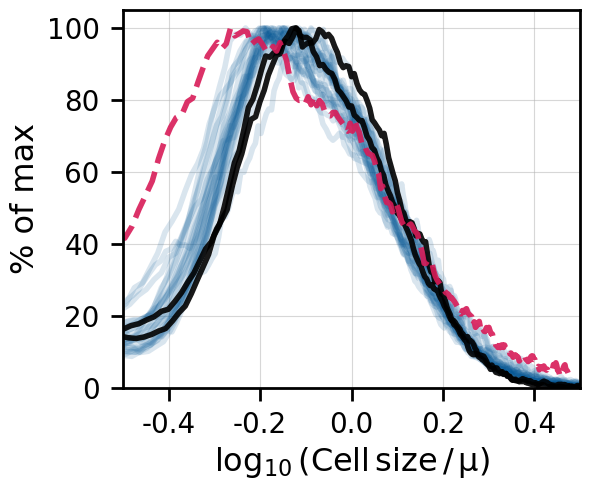

In [15]:
mean_sub_processed_data = np.zeros_like(volume_data_processed)
for i in range(len(volume_data_processed[:,0])):
	mean_sub_processed_data[i,:] = volume_data_processed[i,:]/mean_counts_processed[i]
mean_sub_processed_data = np.delete(mean_sub_processed_data,0,axis=1)
mean_sub_processed_data = np.log10(mean_sub_processed_data)

max_frac_data_processed_smooth = np.amax(frac_data_processed_smooth[:,20:],axis=1)
cmap = mpl.colormaps['Set2']
n_colors = 8
cw = cmap(np.linspace(0,1,n_colors))
f,ax = plt.subplots(1,1,figsize=(6,5),tight_layout=True)
ax = set_axes(ax)
n_mutants_processed=29
for i in range(n_mutants_processed):
    c = cw[i%n_colors][:-1]
    if i in weird_mutants:
        continue
    if (i == (len(volume_data_processed[:,0])-1)) or (i == (len(volume_data_processed[:,0])-2)):
        ax.plot(mean_sub_processed_data[i,window_radius:-window_radius],frac_data_processed_smooth[i,1:]*100/max_frac_data_processed_smooth[i],
            linewidth=big_lw,color='k',alpha=0.9,zorder=2,label='%s , CV = %.3f'%(mutant_keys_processed[1,i],cv_counts_processed_smooth[i]))
    elif mutant_keys_processed[1,i]=='CDH1':
        ax.plot(mean_sub_processed_data[i,window_radius:-window_radius],frac_data_processed_smooth[i,1:]*100/max_frac_data_processed_smooth[i],
            linewidth=big_lw,linestyle='--',zorder=3,color=[216/255, 27/255, 88/255],alpha=0.9,label='%s , CV = %.3f'%(mutant_keys_processed[1,i],cv_counts_processed_smooth[i]))
    else:
        ax.plot(mean_sub_processed_data[i,window_radius:-window_radius],frac_data_processed_smooth[i,1:]*100/max_frac_data_processed_smooth[i],
            linewidth=big_lw,alpha=0.15,color=[0, 84/255, 147/255],label='%s, CV = %.3f'%(mutant_keys_processed[1,i],cv_counts_processed_smooth[i]))

ax.set_xticks([-0.4,-0.2,0,0.2,0.4])
ax.set_xticklabels(['-0.4','-0.2','0.0','0.2','0.4'])
ax.set_yticks([0,20,40,60,80,100])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0, 105])
ax.set_xlabel(r'$\log_{10}(\mathrm{Cell\,size\,/\,\mu})$',size=ax_fontdict['size']+3)
ax.set_ylabel(r'% of max',size=ax_fontdict['size']+3)
plt.grid(zorder=0,alpha=0.5)
#ax.set_title('Mean-subtracted logarithm of the smoothed processed data set')
#ax.legend(prop={'size':4})
#plt.savefig(save_path+'frac_processed_smooth_data_lite.png',dpi=dpi)
plt.show()
plt.close()

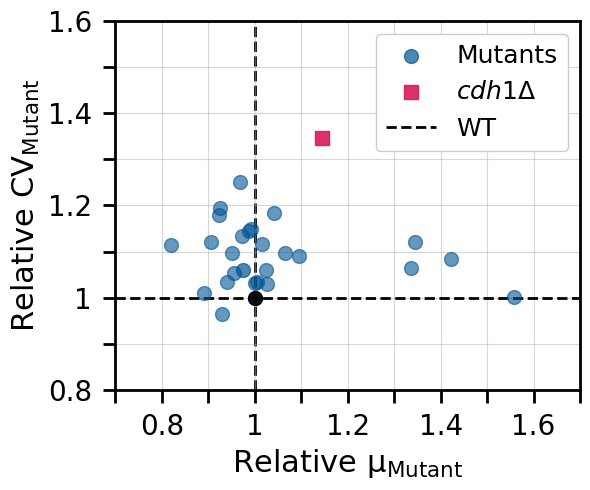

In [16]:
###################################
      # CV and AV scatter plot #
###################################
normalized_mean = mean_counts_processed/mean_counts_processed[-2]
normalized_cv = cv_counts_processed/cv_counts_processed[-2]

f, ax = plt.subplots(1,1,figsize=(6,5),tight_layout=True)
ax = set_axes(ax)
linreg = LinearRegression().fit(normalized_mean.reshape(-1,1),normalized_cv.reshape(-1,1))
linreg_score = linreg.score(normalized_mean.reshape(-1,1),normalized_cv.reshape(-1,1))
linreg_slope = linreg.coef_[0][0]
x_linreg = np.linspace(min(normalized_mean),max(normalized_mean),25)
y_linreg = linreg.predict(x_linreg.reshape(-1,1))

markers = ('o','v','s','*')
for i in range(len(mean_counts_processed)-1):
    if i == 0:
        ax.scatter(normalized_mean[i],normalized_cv[i],s=100,alpha=0.7,zorder=3,marker='o',color=[0, 84/255, 147/255],label='Mutants')
    elif mutant_keys_processed[1,i]=='CDH1':
        ax.scatter(normalized_mean[i],normalized_cv[i],s=100,alpha=0.9,zorder=3,marker='s',color=[216/255, 27/255, 88/255],label=r"$\mathit{cdh1\Delta}$")

    else:
#ax.scatter(normalized_mean[i],normalized_cv[i],alpha=0.75,marker=markers[i//10],label=mutant_keys_processed[1,i])
        ax.scatter(normalized_mean[i],normalized_cv[i],s=100,alpha=0.6,zorder=3,marker='o',color=[0, 84/255, 147/255])

ax.scatter(normalized_mean[i],normalized_cv[i],s=100,alpha=0.9,zorder=3,marker='o',color='k')    
plt.axvline(1,linestyle='--',color='k',lw=small_lw,alpha=1,zorder=1,label='WT')
plt.axhline(1,linestyle='--',color='k',lw=small_lw,alpha=1,zorder=2)
#plt.plot(x_linreg,y_linreg,color='crimson',alpha=0.8,lw=small_lw,zorder=2,label='Fit, slope = %.3f \nR² score = %.3f'%(linreg_slope,linreg_score))
#ax.set_title('Scatter plot of the normalized CV and the Mean of the mutants')
ax.set_ylabel(r'Relative CV$\rm _{Mutant}$',size=ax_fontdict['size']+2)
ax.set_xlabel(r'Relative $\rm \mu_{Mutant}$',size=ax_fontdict['size']+2)

#ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
#ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.set_xticks([0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7])
ax.set_yticks([0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6])
ax.set_xticklabels(['','0.8','','1','','1.2','','1.4','','1.6',''])
ax.set_yticklabels(['0.8','','1','','1.2','','1.4','','1.6'])

#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.set_xlim([0.7,1.7])
ax.set_ylim([0.8,1.6])
plt.grid(zorder=0,alpha=0.5)
plt.legend(prop={'size':18},framealpha=1)
#plt.savefig(save_path+'mean_cv_scatter_lite.png',dpi=dpi)
plt.show()
plt.close()
